In [20]:
import os
import sys
import warnings
from datetime import date

import pandas as pd
#import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError
from numpy import cumsum, log, polyfit, sqrt, std, subtract

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from scipy.stats import probplot, moment

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error, mean_absolute_error

from functions import print_shape, df_security_code

# some example data
import tensorflow as tf


from tqdm import tqdm_notebook,tqdm
from itertools import product

from sklearn.metrics import mean_absolute_percentage_error as MAPE


import warnings
warnings.filterwarnings('ignore')


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', color_codes=True)

# VAR functions

In [4]:
def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [5]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [6]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

In [7]:
def durbin_watson_test(df=None, resid=None):
    cols, stat = [], []
    out = durbin_watson(resid)
    for col, val in zip(df.columns, out):
        cols.append(col)
        stat.append(round(val, 2))
    dw_test = pd.DataFrame(stat, index=cols)
    return dw_test

In [252]:
def transform(df, amount = 3 ,feature = 'ad_Close', first = True, selected = None):
    from functions import df_security_code
    feat = ['Date', 'SecuritiesCode' , feature]
    df = df[feat]
    con_df = pd.DataFrame()
    if selected == None:
        unique_codes = df.SecuritiesCode.unique()[:amount]
    else:
        unique_codes = selected

    for cod in tqdm(unique_codes):
        if cod != 4684 or cod != 4686: 
            df_code = df_security_code(df, cod)
            df_code = df_code[['Date', feature]].set_index(['Date'])
            df_code = df_code.rename(columns = {feature: 'ad_Close_'+str(cod)})
            con_df = pd.concat([con_df, df_code], axis=1)
            
    return con_df

In [18]:
def var_binned(df, split = 10, range = 'y', metric = 'MAPE', exog = None, feature = 'ad_Close', stock_count = 3, drop_na = True, drop_axis = 1, maxlags = 12, plot_predicton = False, ml_flow = False):
    """_summary_

    Args:
        df (_type_): _timeseries Dataframe needed_

        split (str, optional): _Days to predict_. Defaults to '10'.

        range (str, optional): _Range of years for the train data_. Defaults to 'y'.

        metric (str, optional): _Metric chosen _. Defaults to 'MAPE'.

        exog (_type_, optional): _External data that should be considered_. Defaults to None.

        feature (str, optional): _Feature that should be predicted_. Defaults to 'ad_Close'.

        stock_count (int, optional): _amount of stocks_. Defaults to 3.

        drop_na (bool, optional): _Drops all features with NaN values_. Defaults to True.

        drop_axis (int, optional): _1 drops all columns with NaN / only drops Rows_. Defaults to 1.

        maxlags (int, optional): _Checks for the best p in X lags_. Defaults to 12.

        plot_predicton (bool, optional): _Plots the prediction_. Defaults to False.
        
        ml_flow (bool, optional): _Uploads results to ML Flow_. Defaults to False.
    """
    final = []
    final_name = []
    avg_preds = {}
    preds = {}

    if ml_flow == True:
        TRACKING_URI = open(".mlflow_uri").read().strip()


        # setting the MLFlow connection and experiment
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment(EXPERIMENT_NAME)
        mlflow.start_run()
        run = mlflow.active_run()

    df = transform(df, amount=stock_count, feature=feature)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)

    extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(df)
            
    df_ex_low = df[extrem_low_price]
    df_low = df[low_price]
    df_med = df[med_price]
    df_high = df[high_price]
    df_ex_high = df[extrem_high_price]

    #return df_ex_low, df_low, df_med, df_high, df_ex_high

    
    curr_var = [df_ex_low, df_low, df_med, df_high, df_ex_high]
    curr_var_name = ["df_ex_low", "df_low", "df_med", "df_high", "df_ex_high"]

    for dfs,names in zip(curr_var, curr_var_name):
        if dfs.shape[1] > 1:
            final.append(dfs)
            final_name.append(names)

    #display(final_name)
    
    for df_part, name in zip(final,final_name):

        #display(name, df_part)
        
        train_df = df_part[:-split]
        test_df = df_part[-split:]

        df_differenced = train_df.diff().dropna()

        model = VAR(df_differenced)
        x = model.select_order(maxlags=maxlags)
        print(x.summary())

        for i in train_df.columns:
            print(f"Stock {i}")
            display(plot_acf(train_df[i]))


        try:
            p = int(input(f"Enter p depending on AIC-Score 0 - {maxlags}"))
            q = int(input("Enter q based on acf plot"))
        except ValueError:
            print('error')


        order = (p,q)

        with tf.device('/cpu:0'):
            var_model = VARMAX(train_df, order=order, enforce_stationarity=True, exog=exog)
            model_fitted = var_model.fit(disp=False)
            #model_fitted.summary()
        
        n_forcast = split-1
        start_point = len(train_df)

        pred = model_fitted.get_prediction(start=start_point, end=(start_point+n_forcast))

        predictions = pred.predicted_mean

        predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

        if plot_predicton == True:
            for i in predictions.columns:

                plt.figure(figsize=(15,8))

                sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
                sns.lineplot(predictions.index, predictions[i], color="red")
                sns.lineplot(test_df.index, test_df[i], color="blue")

                plt.ylabel("Price in $",fontsize=15)
                plt.xlabel("",fontsize=1)
                plt.yticks(size = 10)
                plt.xticks(size = 10, rotation = 45)
                plt.title('SecuritiesCode_' + i, fontsize = 15)
                plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
                plt.grid(axis='y')
                plt.show()

        if metric == "RMSE":
            average_RMSE_test = []
            for i in predictions.columns:
                cur_rmse = mse(y_pred=predictions[i], y_true=test_df[i], squared=False)
                average_RMSE_test.append(cur_rmse)
                print(f"{i} has a RMSE score of : {cur_rmse} %")
            average_RMSE_test = round(sum(average_RMSE_test)/len(average_RMSE_test),2)
            print(f"The average RMSE score is : {average_RMSE_test} %")

        if metric == "MAPE":
            average_MAPE_test = []
            for i in predictions.columns:
                cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
                average_MAPE_test.append(cur)
                print(f"{i} has a MAPE score of : {cur} %") 
            average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)
            print(f"The average MAPE score is : {average_MAPE_test} %")

        model_type = 'VARMAX'

        if ml_flow == True:
            params = {
            "model": model_type,
            "stock_count": stock_count,
            "split_size": split,
            "selected_order_p/q": order,
            "enforce_stationarity": True
            }

            #logging params to mlflow
            mlflow.log_params(params)
            #setting tags
            mlflow.set_tag("running_from_jupyter", "True")
            #logging metrics
            if metric == "RMSE":
                mlflow.log_metric("test-" + "avg_RMSE", average_RMSE_test)
                mlflow.end_run()
            else:
                mlflow.log_metric("test-" + "avg_MAPE", average_MAPE_test)
                mlflow.end_run()

        if metric == "RMSE":
            avg_preds.update({f'{name}_avg_RMSE': average_RMSE_test})
        else:
            avg_preds.update({f'{name}_avg_MAPE': average_MAPE_test})

        preds.update({f'{name}': predictions})
        
    return avg_preds, preds


In [29]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [32]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

In [230]:
def bin_columns(df):    
    extrem_low_price = []
    low_price = []
    med_price = []
    high_price = []
    extrem_high_price = []

    variables = [extrem_low_price, low_price, med_price, high_price, extrem_high_price]

    for sec in df.columns:

        if int(max(df[sec])) < 500:
            extrem_low_price.append(sec)

        if max(df[sec]) >= 500 and max(df[sec]) < 2000 :
            low_price.append(sec)

        if max(df[sec]) >= 2000 and max(df[sec]) < 4000 :
            med_price.append(sec)

        if max(df[sec]) >= 4000 and max(df[sec]) < 8000 :
            high_price.append(sec)

        if max(df[sec]) >= 8000 :
            extrem_high_price.append(sec)

    for va in variables:
        if len(va) == 0:
            continue
        elif len(va) == 1:
            if va == extrem_low_price:
                low_price.append(extrem_low_price[0])
                extrem_low_price = []

            elif va == low_price:
                med_price.append(low_price[0])
                low_price = []

            elif va == med_price:
                high_price.append(med_price[0])
                med_price = []

            elif va == high_price:
                extrem_high_price.append(high_price[0])
                high_price = []

            elif va == extrem_high_price:
                if len(high_price) >= 1:
                    high_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(med_price) >= 1:
                    med_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(low_price) >= 1:
                    low_price.append(extrem_high_price[0])
                    extrem_high_price = []
                elif len(extrem_low_price) >= 1:
                    extrem_low_price.append(extrem_high_price[0])
                    extrem_high_price = []

    return extrem_low_price, low_price, med_price, high_price, extrem_high_price

# Load Data

In [228]:
df = pd.read_csv("data/curr_price_financial.csv", parse_dates=['Date'], index_col=[0])

In [169]:
df = transform(df, amount=3)

100%|██████████| 3/3 [00:00<00:00, 89.18it/s]


# Test run

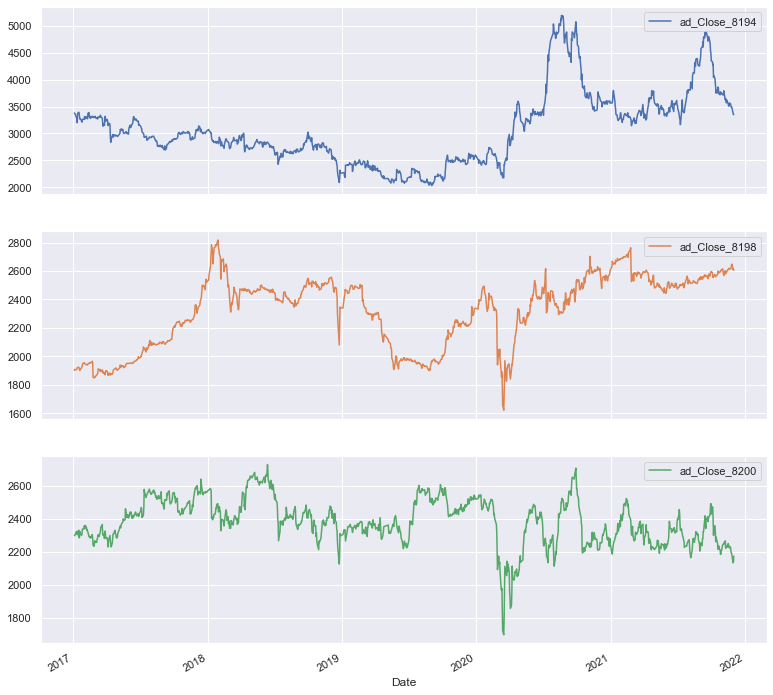

In [170]:
df.plot(subplots=True, figsize=(13,13));

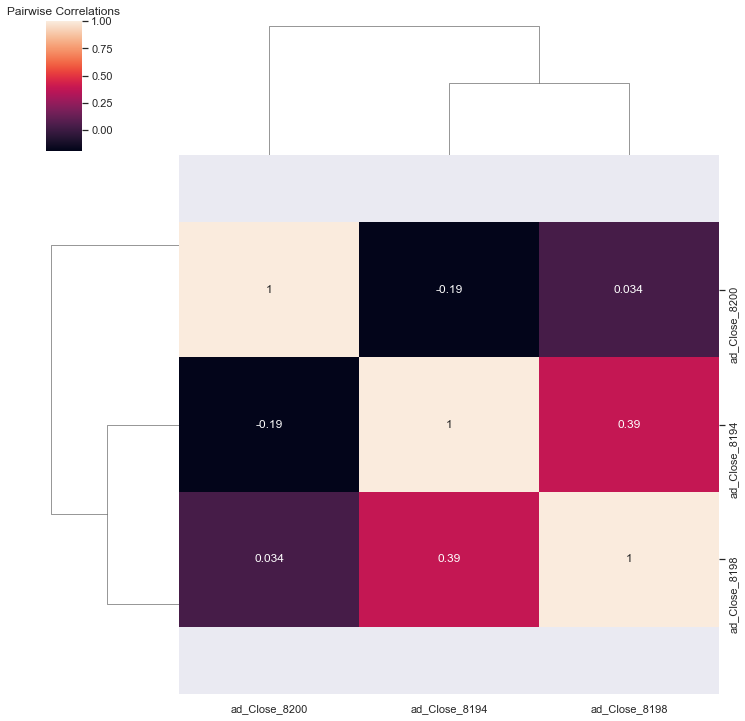

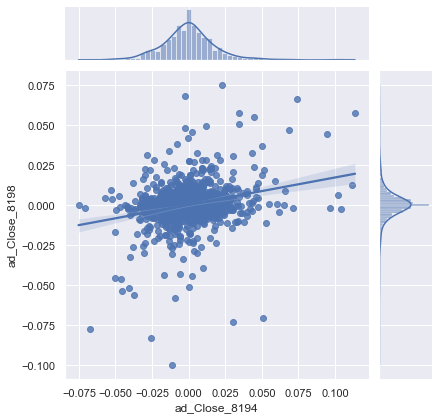

In [171]:
g = sns.clustermap(df.corr(), annot=True)
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

sns.jointplot(x=df.ad_Close_8194.pct_change().dropna(), y=df.ad_Close_8198.pct_change().dropna(), kind="reg");

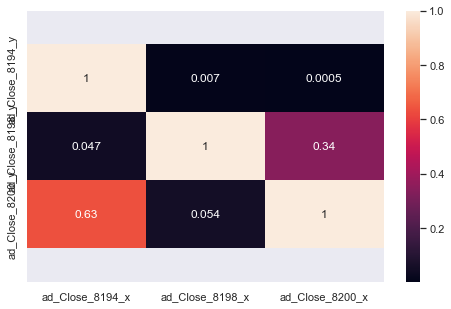

In [172]:
maxlag = 12
test = 'ssr_chi2test'

grangers_df = grangers_causation_matrix(df, variables = df.columns) 

plt.figure(figsize=(8,5))
sns.heatmap(grangers_df, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

In [173]:
pairs = grangers_df.unstack()
pairs = pairs.sort_values(kind="quicksort")
mask = pairs < 0.05

print("Significan Pairs")
print(pairs[mask])

Significan Pairs
ad_Close_8200_x  ad_Close_8194_y    0.0005
ad_Close_8198_x  ad_Close_8194_y    0.0070
ad_Close_8194_x  ad_Close_8198_y    0.0473
dtype: float64


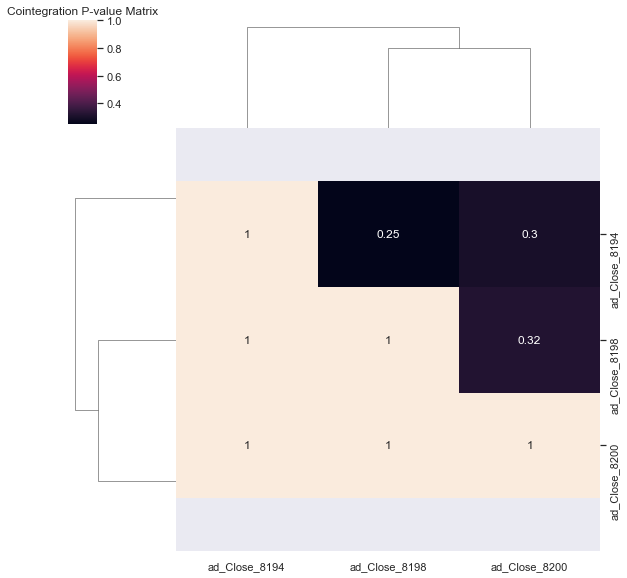

In [174]:
pvalue_matrix, pairs = find_cointegrated_pairs(df)
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=df.columns,yticklabels=df.columns, annot=True, 
                   figsize=(8, 8))
plt.title('Cointegration P-value Matrix')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [175]:
pairs

[]

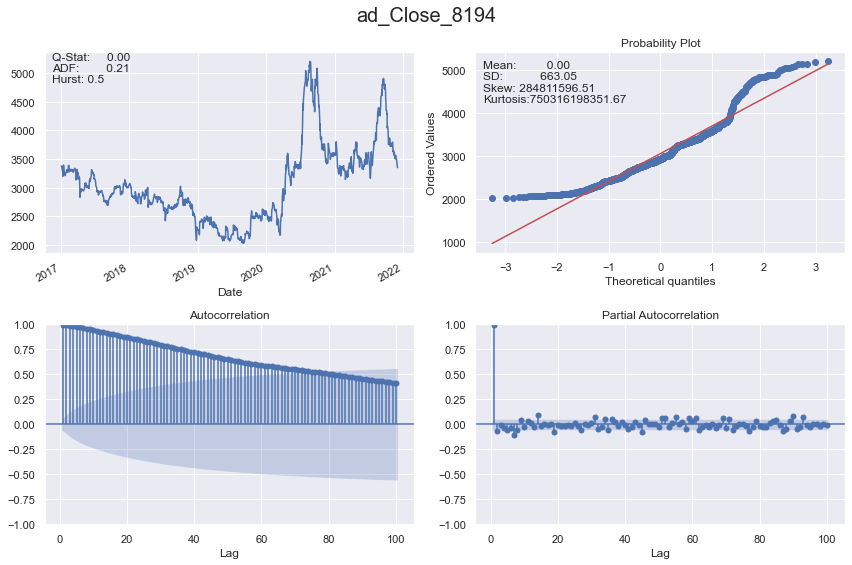

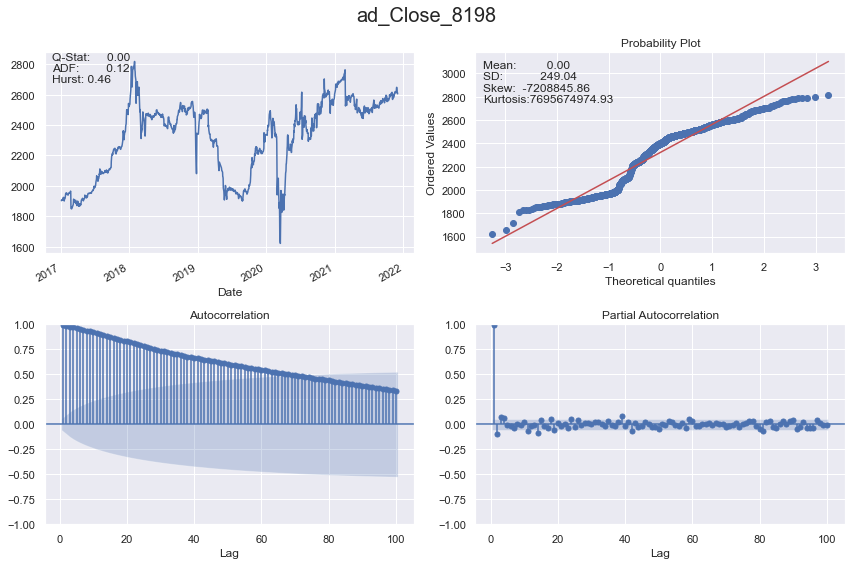

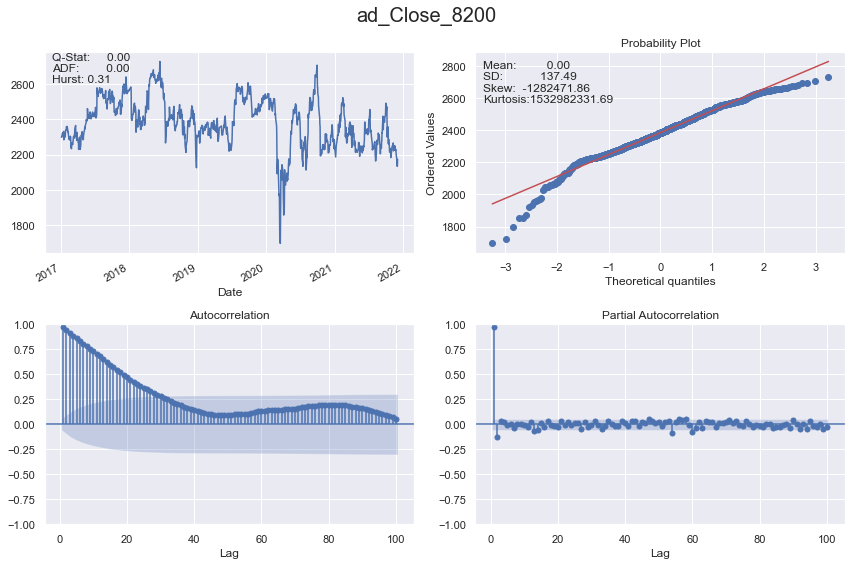

In [176]:
for i in df.columns:
    plot_correlogram(df[i], lags=100, title=f'{i}')

In [224]:
curr_data = {}
for i in df.columns:
    curr_data.update({f'{i}': df[i].diff()})

df_transformed = pd.DataFrame(curr_data).dropna()

In [225]:
df_transformed

,ad_Close_8194,ad_Close_8198,ad_Close_8200
Date,,,
2017-01-05,-5.0,5.0,1.0
2017-01-06,-10.0,-2.0,3.0
2017-01-10,-70.0,1.0,21.0
2017-01-11,-20.0,9.0,1.0
2017-01-12,-75.0,4.0,-21.0
...,...,...,...
2021-11-25,5.0,21.0,-2.0
2021-11-26,-15.0,5.0,-10.0
2021-11-29,-100.0,-38.0,-48.0


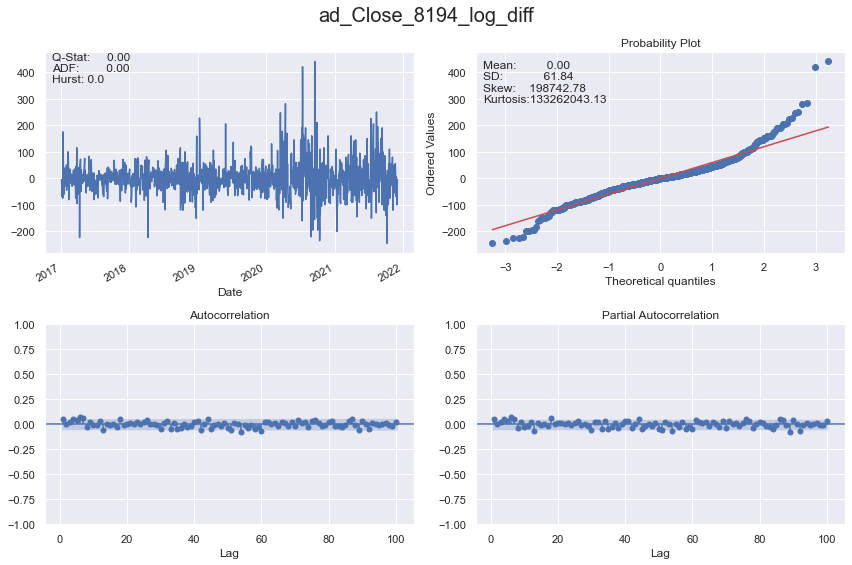

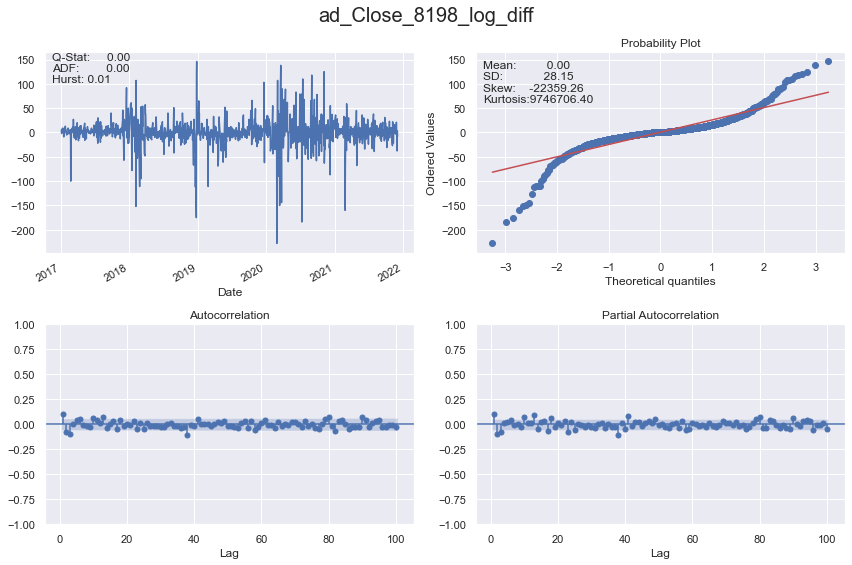

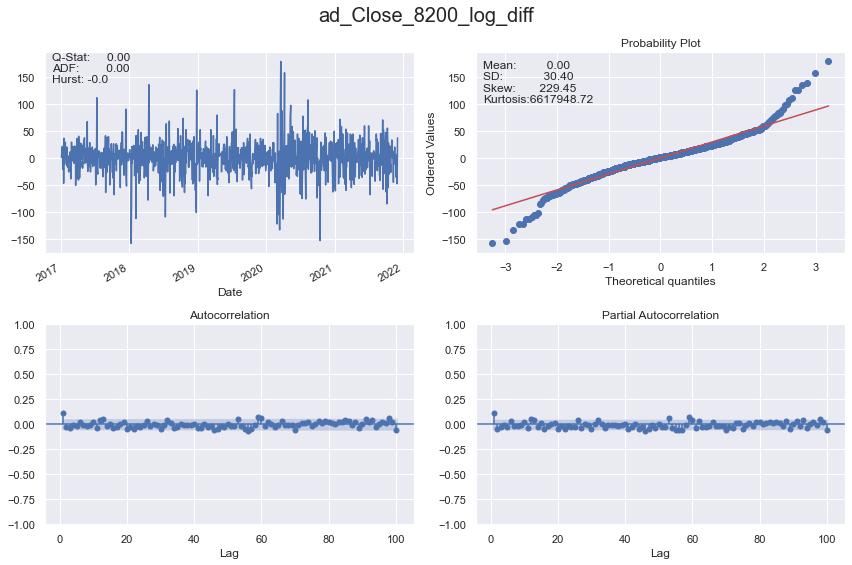

In [198]:
for i in df_transformed.columns:
    plot_correlogram(df_transformed[i], lags=100, title=f'{i}_log_diff')

In [199]:
test_unit_root(df_transformed)

,p-value
ad_Close_8194,0.00%
ad_Close_8198,0.00%
ad_Close_8200,0.00%


In [200]:
#split = int(len(df) * 0.91)
split = 10

df_train, df_test = df_transformed.iloc[:split], df_transformed.iloc[split:]
print(df_train.info())  
print(df_test.info()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2017-01-05 to 2017-01-19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ad_Close_8194  10 non-null     float64
 1   ad_Close_8198  10 non-null     float64
 2   ad_Close_8200  10 non-null     float64
dtypes: float64(3)
memory usage: 320.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1189 entries, 2017-01-20 to 2021-12-01
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ad_Close_8194  1189 non-null   float64
 1   ad_Close_8198  1189 non-null   float64
 2   ad_Close_8200  1189 non-null   float64
dtypes: float64(3)
memory usage: 37.2 KB
None


In [201]:
test_results = {}

for p in range(5):
    for q in range(5):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')
        convergence_error = stationarity_error = 0
        
        try:
            model = VARMAX(df_train, order=(p,q), trend='n')
            model_result = model.fit(maxiter=1000, disp=False)
                
        except LinAlgError:
            convergence_error += 1
                
        except ValueError:
            stationarity_error += 1
                
        print('\nAIC:', model_result.aic)
        print('BIC:', model_result.bic)
        print('HQIC:', model_result.hqic)
        print('------------------------')

        test_results[(p, q)] = [model_result.aic,
                                model_result.bic,
                                convergence_error,
                                stationarity_error]

Testing Order: p = 0, q = 1

AIC: 269.363745580716
BIC: 273.90252197562666
HQIC: 264.38471893815466
------------------------
Testing Order: p = 0, q = 2

AIC: 252.97906163917972
BIC: 260.24110387103684
HQIC: 245.0126190110816
------------------------
Testing Order: p = 0, q = 3

AIC: 252.97906163917972
BIC: 260.24110387103684
HQIC: 245.0126190110816
------------------------
Testing Order: p = 0, q = 4

AIC: 303.40085103892676
BIC: 316.1094249446767
HQIC: 289.45957643975504
------------------------
Testing Order: p = 1, q = 0

AIC: 284.5180189587959
BIC: 289.05679535370655
HQIC: 279.53899231623456
------------------------
Testing Order: p = 1, q = 1

AIC: 287.3187894865319
BIC: 294.580831718389
HQIC: 279.3523468584338
------------------------
Testing Order: p = 1, q = 2

AIC: 284.7522707224237
BIC: 294.73757879122724
HQIC: 273.7984121087888
------------------------
Testing Order: p = 1, q = 3

AIC: 309.95578608180165
BIC: 322.6643599875516
HQIC: 296.01451148263
------------------------


In [202]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AIC           24 non-null     float64
 1   BIC           24 non-null     float64
 2   convergence   24 non-null     float64
 3   stationarity  24 non-null     float64
dtypes: float64(4)
memory usage: 1.3 KB


In [203]:
test_results.sort_values('BIC').head()

AIC         BIC  convergence  stationarity
p q                                                   
0 2  252.979062  260.241104          0.0           0.0
  3  252.979062  260.241104          1.0           0.0
  1  269.363746  273.902522          0.0           0.0
1 0  284.518019  289.056795          0.0           0.0
  1  287.318789  294.580832          0.0           0.0

In [204]:
order = test_results['AIC'].idxmin()

In [205]:
model = VARMAX(df_train, order= order, trend='n').fit(maxiter=1000, disp=False)
#model.summary()

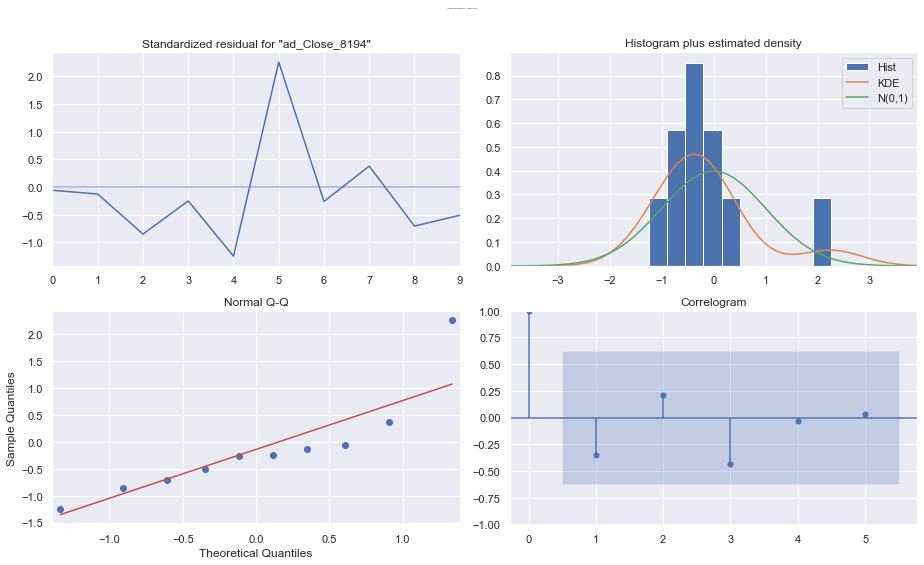

In [206]:
model.plot_diagnostics(variable=0, figsize=(13,8), lags=5)
plt.gcf().suptitle('ad_Close_8194 - Diagnostics', fontsize=2)
plt.tight_layout()
plt.subplots_adjust(top=.9);

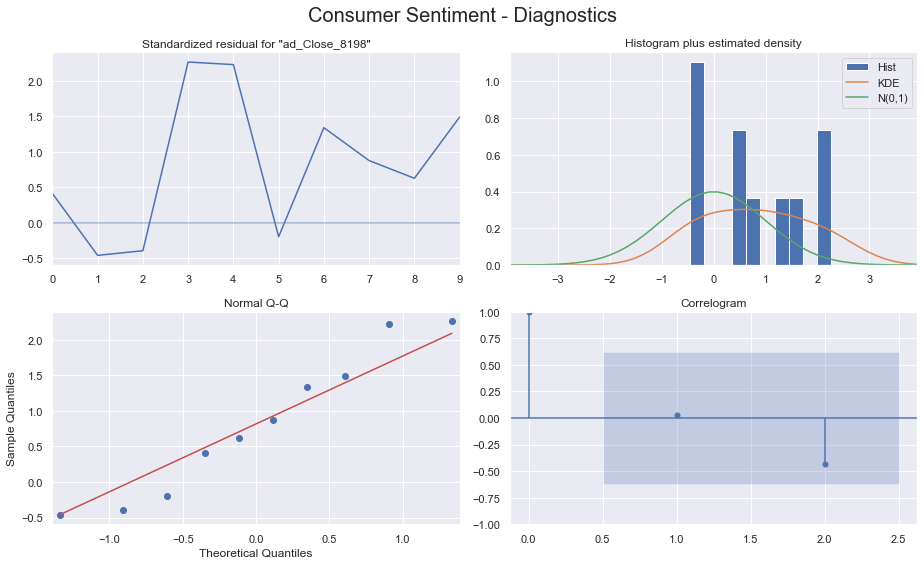

In [207]:
model.plot_diagnostics(variable=1, figsize=(13,8), lags=2)
plt.gcf().suptitle('ad_Close_8198 - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

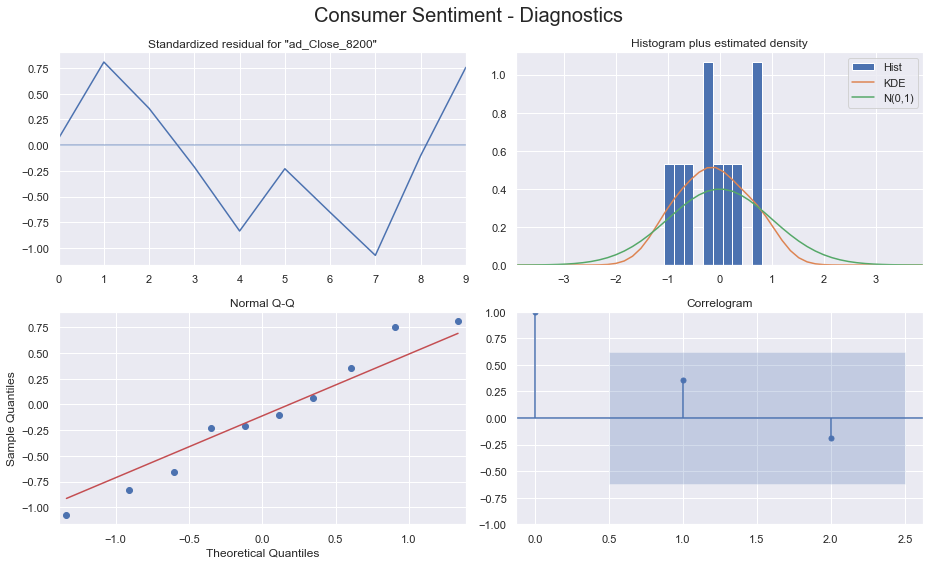

In [208]:
model.plot_diagnostics(variable=2, figsize=(13,8), lags=2)
plt.gcf().suptitle('ad_Close_8200 - Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

In [ ]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12, impulse=median_change).plot.bar(subplots=True, figsize=(13,13));

In [210]:
durbin_watson_test(df=df_transformed, resid=model.resid)

,0
ad_Close_8194,2.62
ad_Close_8198,2.60
ad_Close_8200,1.36


In [217]:
df_transformed.shape

(1199, 3)

# Gridsearch Var

In [259]:
def var_gridsearch(df, split = 10, metric = 'MAPE',selected=None , exog = None, feature = 'ad_Close', stock_count = 3, drop_na = True, drop_axis = 1, maxlags = 12, plot_predicton = False, ml_flow = False):
    """_summary_

    Args:
        df (_type_): _timeseries Dataframe needed_

        split (str, optional): _Days to predict_. Defaults to '10'.

        range (str, optional): _Range of years for the train data_. Defaults to 'y'.

        metric (str, optional): _Metric chosen _. Defaults to 'MAPE'.

        exog (_type_, optional): _External data that should be considered_. Defaults to None.

        feature (str, optional): _Feature that should be predicted_. Defaults to 'ad_Close'.

        stock_count (int, optional): _amount of stocks_. Defaults to 3.

        drop_na (bool, optional): _Drops all features with NaN values_. Defaults to True.

        drop_axis (int, optional): _1 drops all columns with NaN / only drops Rows_. Defaults to 1.

        maxlags (int, optional): _Checks for the best p in X lags_. Defaults to 12.

        plot_predicton (bool, optional): _Plots the prediction_. Defaults to False.
        
        ml_flow (bool, optional): _Uploads results to ML Flow_. Defaults to False.
    """
    final = []
    final_name = []
    avg_preds = {}
    preds = {}

    if ml_flow == True:
        TRACKING_URI = open(".mlflow_uri").read().strip()


        # setting the MLFlow connection and experiment
        mlflow.set_tracking_uri(TRACKING_URI)
        mlflow.set_experiment(EXPERIMENT_NAME)
        mlflow.start_run()
        run = mlflow.active_run()

    df = transform(df, amount=stock_count, feature=feature, selected=selected)
    if drop_na == True:
        df.dropna(axis = drop_axis, inplace=True)

    extrem_low_price, low_price, med_price, high_price, extrem_high_price = bin_columns(df)
            
    df_ex_low = df[extrem_low_price]
    df_low = df[low_price]
    df_med = df[med_price]
    df_high = df[high_price]
    df_ex_high = df[extrem_high_price]

    #return df_ex_low, df_low, df_med, df_high, df_ex_high

    
    curr_var = [df_ex_low, df_low, df_med, df_high, df_ex_high]
    curr_var_name = ["df_ex_low", "df_low", "df_med", "df_high", "df_ex_high"]

    for dfs,names in zip(curr_var, curr_var_name):
        if dfs.shape[1] > 1:
            final.append(dfs)
            final_name.append(names)

    #display(final_name)
    
    for df_part, name in zip(final,final_name):

        #display(name, df_part)
        curr_data = {}
        for i in df_part.columns:
            curr_data.update({f'{i}': df[i].diff()})

        df_transformed = pd.DataFrame(curr_data).dropna()
        df_train = df_transformed.iloc[:-split]
        test_results = {}

        print(f'Dataframe: {name}')

        for p in tqdm(range(3)):
            for q in range(5):
                if p == 0 and q == 0:
                    continue
                    
                print(f'Testing Order: p = {p}, q = {q}')
                convergence_error = stationarity_error = 0
                
                try:
                    model = VARMAX(df_train, order=(p,q), trend='n')
                    model_result = model.fit(maxiter=1000, disp=False)
                        
                except LinAlgError:
                    convergence_error += 1
                        
                except ValueError:
                    stationarity_error += 1


                test_results[(p, q)] = [model_result.aic,
                                        model_result.bic,
                                        convergence_error,
                                        stationarity_error]

        test_results = pd.DataFrame(test_results).T
        test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
        test_results.index.names = ['p', 'q']

        order = test_results['AIC'].idxmin()
        
        train_df = df_part[:-split]
        test_df = df_part[-split:]


        with tf.device('/cpu:0'):
            var_model = VARMAX(train_df, order=order, enforce_stationarity=True, exog=exog)
            model_fitted = var_model.fit(disp=False)
            #model_fitted.summary()
        
        n_forcast = split-1
        start_point = len(train_df)

        pred = model_fitted.get_prediction(start=start_point, end=(start_point+n_forcast))

        predictions = pred.predicted_mean

        

        predictions = pd.concat([predictions.reset_index(), (test_df.reset_index().Date)], axis=1).drop('index', axis =1).set_index('Date')

        if plot_predicton == True:
            for i in predictions.columns:

                plt.figure(figsize=(15,8))

                sns.lineplot(train_df.index[950:], train_df[i][950:], color="green")
                sns.lineplot(predictions.index, predictions[i], color="red")
                sns.lineplot(test_df.index, test_df[i], color="blue")

                plt.ylabel("Price in $",fontsize=15)
                plt.xlabel("",fontsize=1)
                plt.yticks(size = 10)
                plt.xticks(size = 10, rotation = 45)
                plt.title('SecuritiesCode_' + i, fontsize = 15)
                plt.legend(['Past prices','Predicted price', 'Actual price'], fontsize = 15)
                plt.grid(axis='y')
                plt.show()

        if metric == "RMSE":
            average_RMSE_test = []
            for i in predictions.columns:
                cur_rmse = mse(y_pred=predictions[i], y_true=test_df[i], squared=False)
                average_RMSE_test.append(cur_rmse)
                print(f"{i} has a RMSE score of : {cur_rmse} %")
            average_RMSE_test = round(sum(average_RMSE_test)/len(average_RMSE_test),2)
            print(f"The average RMSE score is : {average_RMSE_test} %")

        if metric == "MAPE":
            average_MAPE_test = []
            for i in predictions.columns:
                cur = round((MAPE(y_pred=predictions[i], y_true=test_df[i]))*100,2) 
                average_MAPE_test.append(cur)
                print(f"{i} has a MAPE score of : {cur} %") 
            average_MAPE_test = round(sum(average_MAPE_test)/len(average_MAPE_test),2)
            print(f"The average MAPE score is : {average_MAPE_test} %")

        model_type = 'VARMAX'

        if ml_flow == True:
            params = {
            "model": model_type,
            "stock_count": stock_count,
            "split_size": split,
            "selected_order_p/q": order,
            "enforce_stationarity": True
            }

            #logging params to mlflow
            mlflow.log_params(params)
            #setting tags
            mlflow.set_tag("running_from_jupyter", "True")
            #logging metrics
            if metric == "RMSE":
                mlflow.log_metric("test-" + "avg_RMSE", average_RMSE_test)
                mlflow.end_run()
            else:
                mlflow.log_metric("test-" + "avg_MAPE", average_MAPE_test)
                mlflow.end_run()

        if metric == "RMSE":
            avg_preds.update({f'{name}_avg_RMSE': average_RMSE_test})
        else:
            avg_preds.update({f'{name}_avg_MAPE': average_MAPE_test})

        preds.update({f'{name}': predictions})
        
    return avg_preds, preds


In [243]:
var_gridsearch(df)

100%|██████████| 3/3 [00:00<00:00, 76.42it/s]


Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 0, q = 3
Testing Order: p = 0, q = 4
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 1, q = 3
Testing Order: p = 1, q = 4
Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2
Testing Order: p = 2, q = 3
Testing Order: p = 2, q = 4
Testing Order: p = 3, q = 0
Testing Order: p = 3, q = 1
Testing Order: p = 3, q = 2
Testing Order: p = 3, q = 3
Testing Order: p = 3, q = 4
Testing Order: p = 4, q = 0
Testing Order: p = 4, q = 1
Testing Order: p = 4, q = 2
Testing Order: p = 4, q = 3
Testing Order: p = 4, q = 4
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-05 16:09:02.608589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-05 16:09:02.610476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ad_Close_8198 has a MAPE score of : 0.87 %
ad_Close_8200 has a MAPE score of : 2.91 %
ad_Close_8194 has a MAPE score of : 2.69 %
The average MAPE score is : 2.16 %


({'df_med_avg_MAPE': 2.16},
 {'df_med':             ad_Close_8198  ad_Close_8200  ad_Close_8194
  Date                                                   
  2021-11-17    2607.703434    2251.795438    3549.061033
  2021-11-18    2605.152866    2252.345065    3550.392956
  2021-11-19    2602.829876    2253.529780    3552.593124
  2021-11-22    2600.542400    2254.702557    3554.732790
  2021-11-24    2598.289856    2255.863417    3556.812742
  2021-11-25    2596.071672    2257.012382    3558.833761
  2021-11-26    2593.887280    2258.149479    3560.796626
  2021-11-29    2591.736125    2259.274739    3562.702112
  2021-11-30    2589.617655    2260.388194    3564.550990
  2021-12-01    2587.531329    2261.489881    3566.344025})

Train last day: November
First pred day = 1. Nov 
Last pred day = 15. Nov

In [263]:
a = [1417, 1969, 4047, 4901, 5195, 6532, 7480, 8304, 8306, 8361, 8388,
            9007, 9008, 9101, 9104, 9107, 9110, 9612]
test = transform(df, selected= a)

100%|██████████| 18/18 [00:00<00:00, 90.53it/s]


In [264]:
test.dropna()

,ad_Close_1417,ad_Close_1969,ad_Close_4047,ad_Close_4901,ad_Close_5195,ad_Close_6532,ad_Close_7480,ad_Close_8304,ad_Close_8306,ad_Close_8361,ad_Close_8388,ad_Close_9007,ad_Close_9008,ad_Close_9101,ad_Close_9104,ad_Close_9107,ad_Close_9110,ad_Close_9612
Date,,,,,,,,,,,,,,,,,,
2017-01-04,1053.0,1532.0,1069.0,4551.0,1069.0,824.0,1035.0,424.0,745.2,473.0,731.0,2361.0,982.0,231.0,342.0,277.0,211.0,1912.0
2017-01-05,1072.0,1541.0,1115.0,4503.0,1057.0,827.0,1034.0,426.0,748.3,468.0,732.0,2373.0,976.0,231.0,346.0,278.0,211.0,1923.0
2017-01-06,1064.0,1538.0,1085.0,4507.0,1051.0,856.0,1033.0,423.0,738.0,468.0,729.0,2411.0,995.0,229.0,342.0,279.0,208.0,1925.0
2017-01-10,1061.0,1537.0,1071.0,4453.0,1046.0,900.0,1035.0,417.0,726.7,461.0,705.0,2353.0,992.0,227.0,341.0,276.0,205.0,1919.0
2017-01-11,1069.0,1539.0,1068.0,4480.0,1050.0,906.0,1034.0,418.0,737.7,463.0,710.0,2361.0,989.0,229.0,348.0,278.0,206.0,1907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2008.0,1966.0,1070.0,9178.0,885.0,49950.0,1700.0,260.6,634.9,185.2,431.6,2278.0,1068.0,751.0,655.0,494.0,332.5,2981.0
2021-11-26,1970.0,1953.0,1037.0,9085.0,873.0,48950.0,1671.0,257.3,623.0,183.5,422.0,2213.0,1040.0,737.0,649.0,481.0,329.5,2948.0
2021-11-29,1935.0,1922.0,1004.0,9020.0,846.0,49200.0,1626.0,250.2,610.1,180.2,415.6,2130.0,998.0,755.0,664.0,494.5,326.5,2920.0


100%|██████████| 18/18 [00:00<00:00, 88.59it/s]


Dataframe: df_ex_low


  0%|          | 0/3 [00:00<?, ?it/s]

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 0, q = 3
Testing Order: p = 0, q = 4


 33%|███▎      | 1/3 [00:21<00:43, 21.51s/it]

Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 1, q = 3
Testing Order: p = 1, q = 4


 67%|██████▋   | 2/3 [05:46<03:20, 200.24s/it]

Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2
Testing Order: p = 2, q = 3
Testing Order: p = 2, q = 4


100%|██████████| 3/3 [16:27<00:00, 329.01s/it]


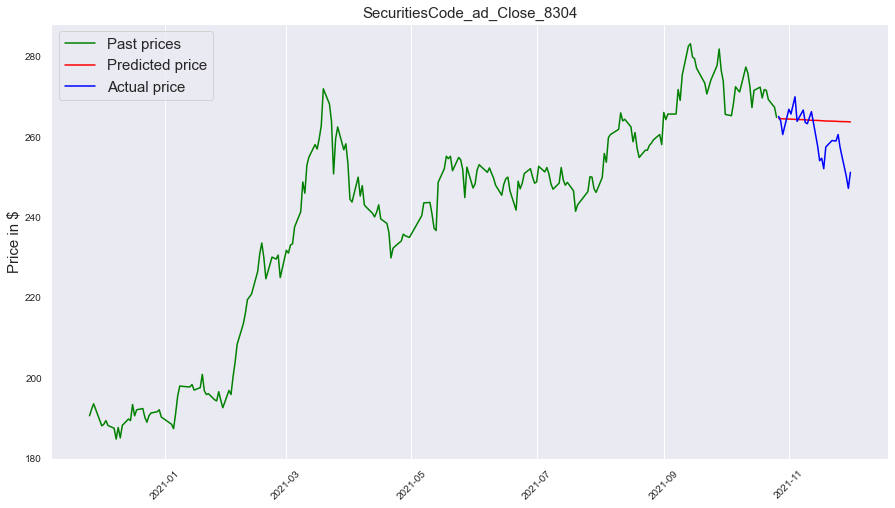

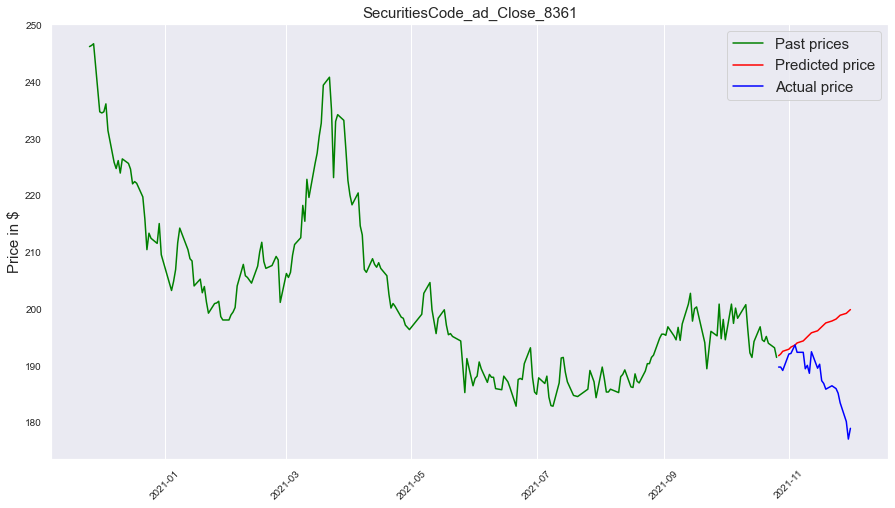

ad_Close_8304 has a MAPE score of : 2.09 %
ad_Close_8361 has a MAPE score of : 4.36 %
The average MAPE score is : 3.22 %
Dataframe: df_low


  0%|          | 0/3 [00:00<?, ?it/s]

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 0, q = 3
Testing Order: p = 0, q = 4


 33%|███▎      | 1/3 [42:42<1:25:25, 2562.55s/it]

Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 1, q = 3
Testing Order: p = 1, q = 4


 67%|██████▋   | 2/3 [1:26:42<43:27, 2607.93s/it]

Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2
Testing Order: p = 2, q = 3
Testing Order: p = 2, q = 4


100%|██████████| 3/3 [2:34:04<00:00, 3081.47s/it]


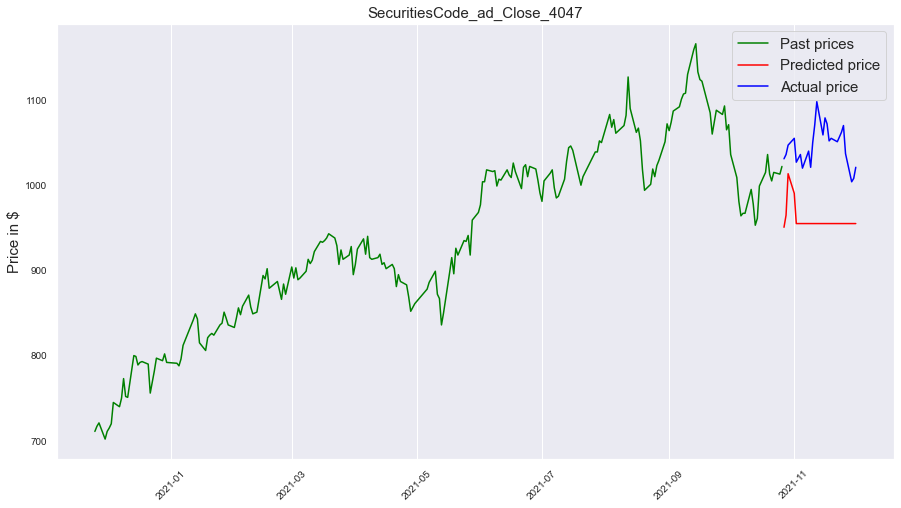

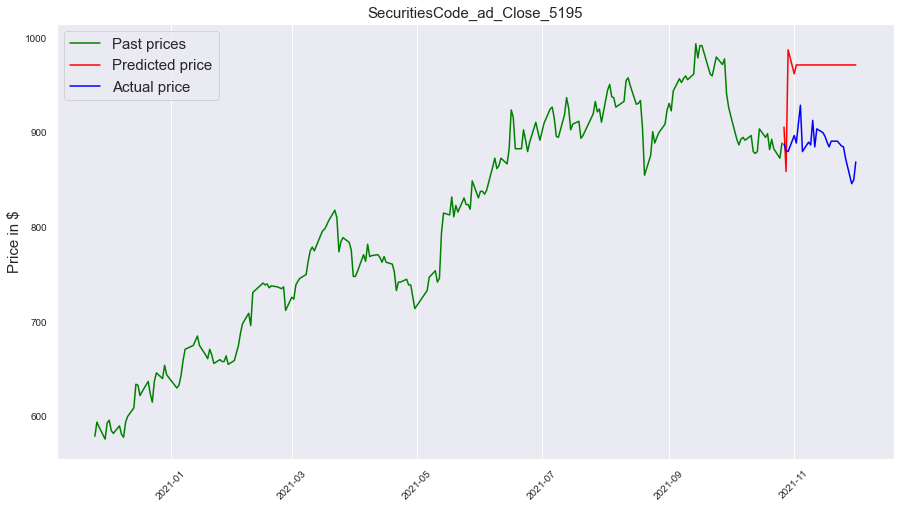

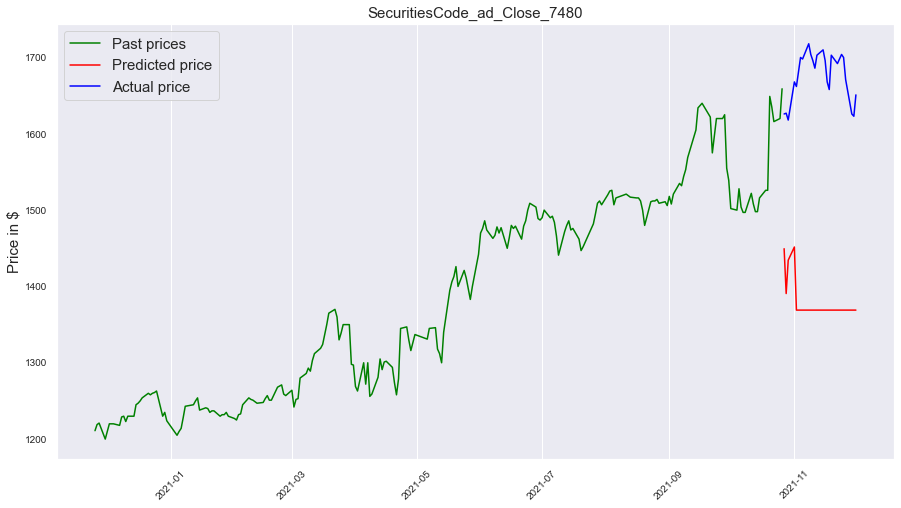

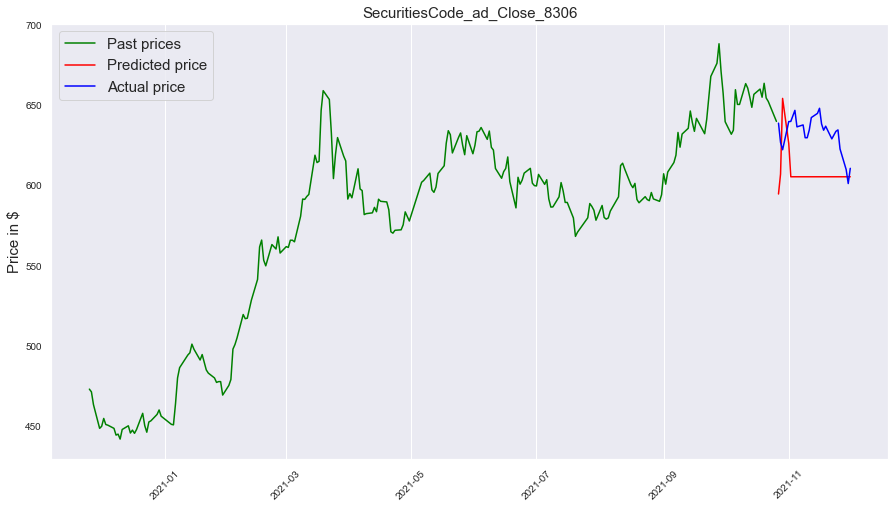

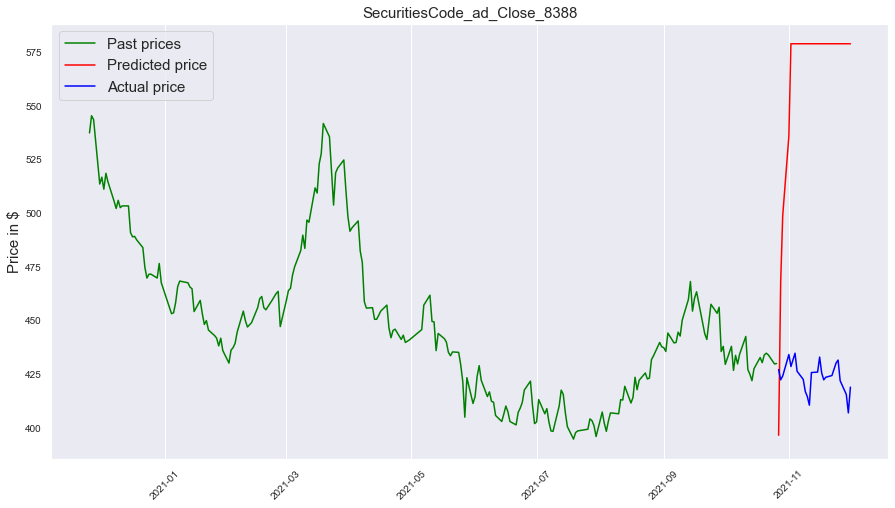

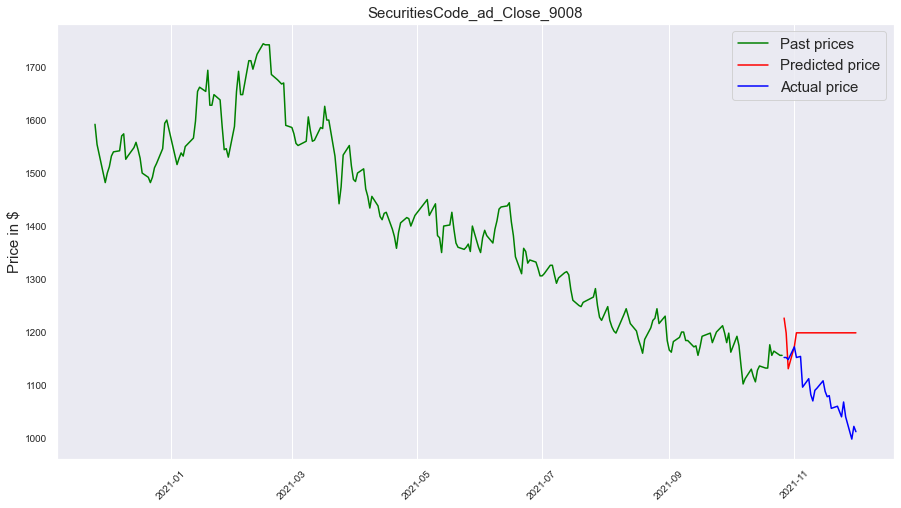

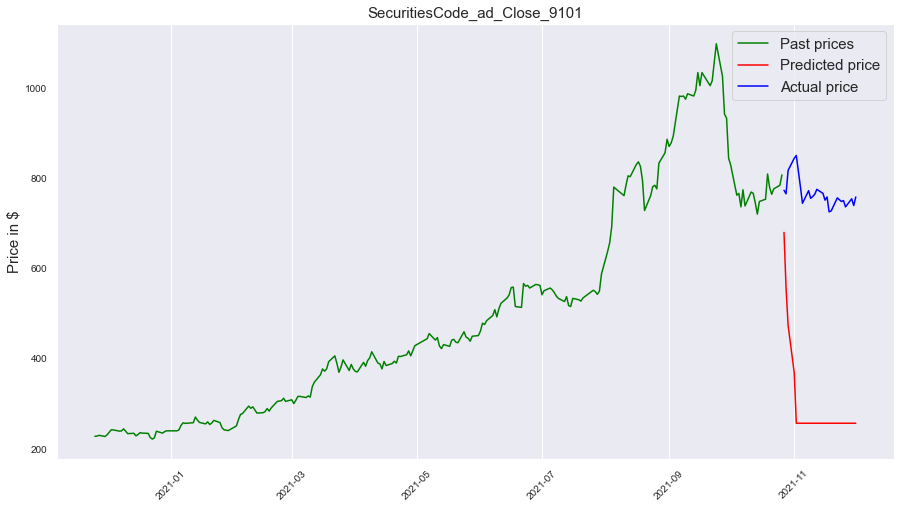

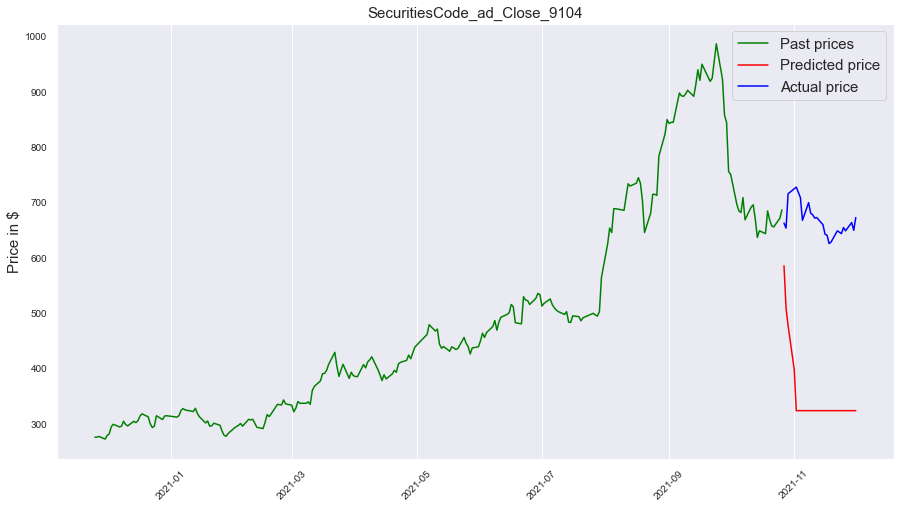

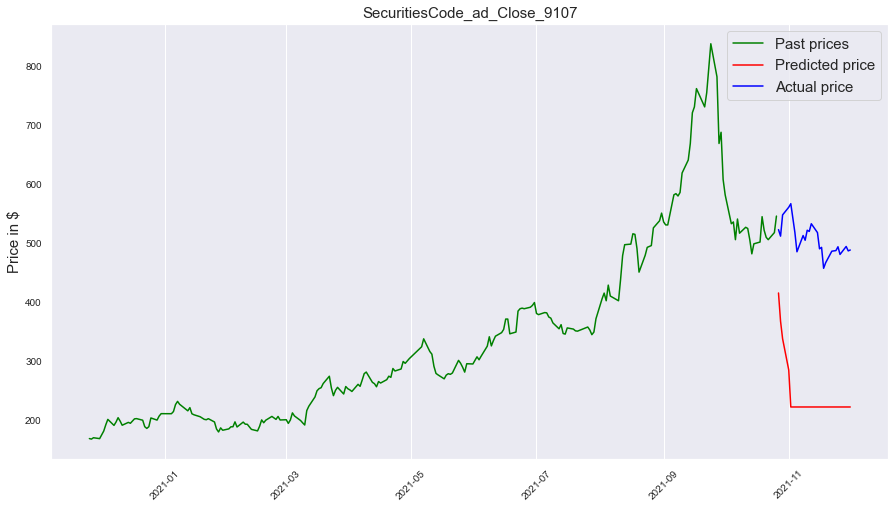

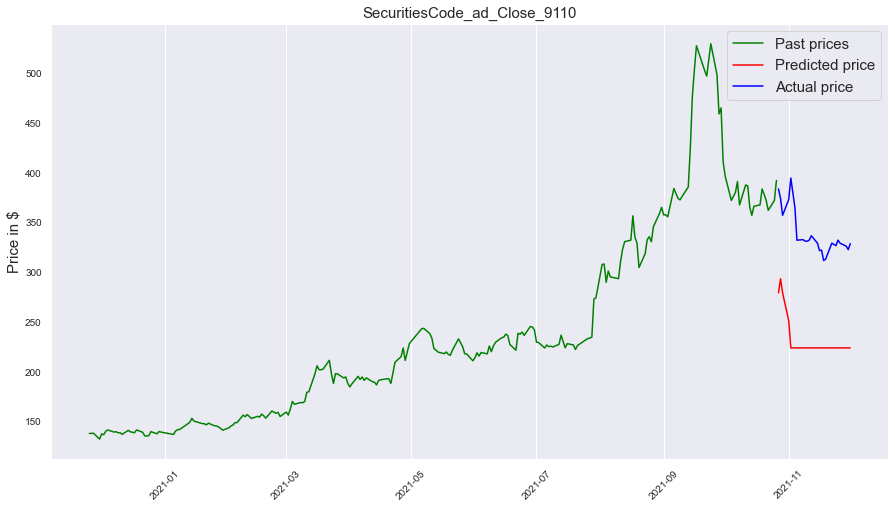

ad_Close_4047 has a MAPE score of : 8.26 %
ad_Close_5195 has a MAPE score of : 8.99 %
ad_Close_7480 has a MAPE score of : 17.62 %
ad_Close_8306 has a MAPE score of : 4.27 %
ad_Close_8388 has a MAPE score of : 33.2 %
ad_Close_9008 has a MAPE score of : 10.2 %
ad_Close_9101 has a MAPE score of : 60.84 %
ad_Close_9104 has a MAPE score of : 47.3 %
ad_Close_9107 has a MAPE score of : 51.87 %
ad_Close_9110 has a MAPE score of : 31.35 %
The average MAPE score is : 27.39 %
Dataframe: df_med


  0%|          | 0/3 [00:00<?, ?it/s]

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 0, q = 3
Testing Order: p = 0, q = 4


 33%|███▎      | 1/3 [05:03<10:07, 303.97s/it]

Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 1, q = 3
Testing Order: p = 1, q = 4


 67%|██████▋   | 2/3 [9:42:02<5:41:28, 20488.97s/it]

Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2
Testing Order: p = 2, q = 3
Testing Order: p = 2, q = 4


 67%|██████▋   | 2/3 [16:40:56<8:20:28, 30028.22s/it]


KeyboardInterrupt: 

In [266]:
var_gridsearch(df, selected=a, plot_predicton=True, split=24)